In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import gradient_descent
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

cuda
[0.4862745  0.38431373 0.3254902 ]


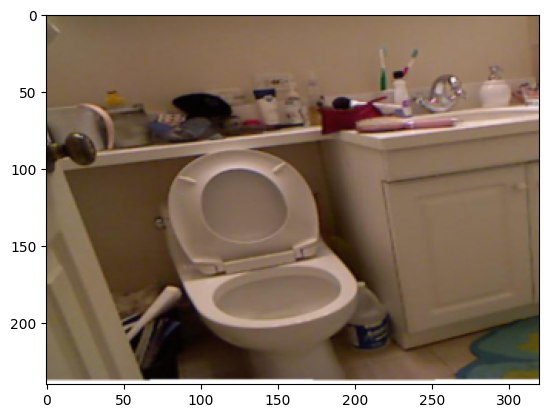

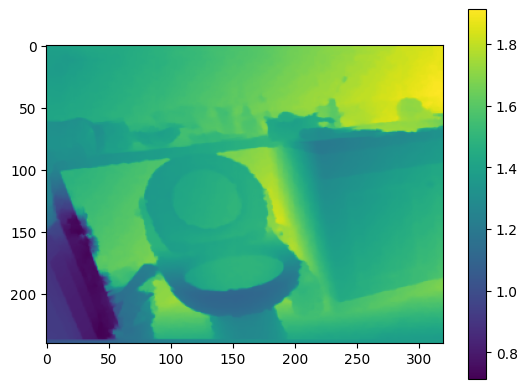

adaptive kernel size set to 11


In [6]:
globals.init_NYUv2()

# EXPERIMENT_NAME = 'coord-descent-bracket-search'
# experiment_folder = utils.create_experiment_folder(EXPERIMENT_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
# gt_aif, gt_dpt = utils.load_single_sample(sample='0101', set='train', fs=5, res='half')
gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

plt.imshow(gt_aif / IMAGE_RANGE)
plt.show()

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

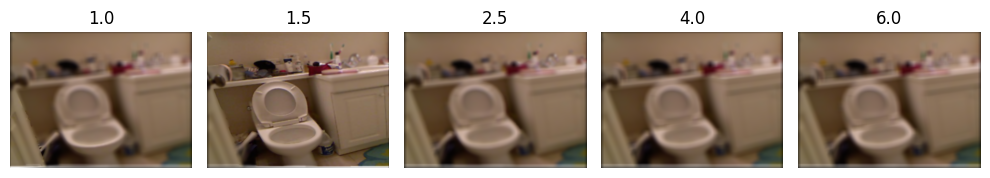

In [7]:
# forward model (torch)
FORWARD_KERNEL_TYPE = 'gaussian'
defocus_stack = forward_model.forward(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)
defocus_stack_torch = forward_model.forward_torch(gt_dpt, gt_aif, kernel=FORWARD_KERNEL_TYPE)#.float() / 255.0)
utils.plot_single_stack(defocus_stack_torch / IMAGE_RANGE, globals.Df)



In [ ]:
# # AIF initialization

# # aif_init = initialization.trivial_aif_initialization(defocus_stack)
# aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05, sharpness_measure='sobel_grad')
# plt.imshow(aif_init / IMAGE_RANGE)
# plt.show()

# plt.imshow(defocus_stack[1] / IMAGE_RANGE)
# plt.show()

In [8]:
# -------------------
# COORDINATE DESCENT
# -------------------

depth_init = 1#torch.median(gt_dpt.cpu()).item()
# print('initializing depth to',depth_init)

dpt, aif, _ = coordinate_descent.coordinate_descent(defocus_stack, show_plots=False,
                                                 save_plots=True, num_epochs=40,
                                                 least_squares_first=True, depth_init=depth_init,
                                                 # least_squares_first=False, aif_init=aif_init,
                                                 aif_method='ls', finite_differences=False, num_Z=100,
                                                 ls_maxiter=50, ls_maxiter_multiplier=1.05,#1.075, 
                                                 use_CUDA=False, vmin = gt_dpt.min(), vmax = gt_dpt.max())


Created experiment folder: experiments/coord-descent_2025-08-07_10-04-43
Images in range [0-255]
Iteration 0 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red   4912.065960  34722.813430      30
  green   4788.336872  28520.664577      30
   blue   4625.418900  23345.141441      31

AIF result range: [ -11.599905498433145 , 255.09595420246478 ]
Loss: 59.419334411621094 , TV: 1196812.7921785857
Loss after clipping: 59.4434928894043 , TV: 1193680.3511948565



Grid search         : 100%|███████████████████| 100/100 [00:18<00:00,  5.56it/s]


Loss: 20.282708423957434

Golden-section search...
...searching for 100 % convergence
...done
Loss: 20.08491929992456 , TV: 83111.68650900865

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 52


--------------------------

Iteration 1 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red   1374.902122  35368.975871      52
  green   1441.522979  29322.303624      52
   blue   1485.576884  24313.759010      52

AIF result range: [ -247.12432857073577 , 453.0709332202529 ]
Loss: 5.3604894262781855 , TV: 5910702.096537975
Loss after clipping: 7.349987862658829 , TV: 5659143.307752371



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.30it/s]


Loss: 4.613783732165196

Golden-section search...
...searching for 100 % convergence
...done
Loss: 4.288827630501444 , TV: 47368.43871388296

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 54


--------------------------

Iteration 2 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    738.913698  35265.548044      54
  green    762.185749  29181.936308      54
   blue    770.778139  24132.171899      54

AIF result range: [ -162.51809723679557 , 535.6647512583465 ]
Loss: 1.493940731268421 , TV: 4682442.96107338
Loss after clipping: 1.9834517820062816 , TV: 4559841.386194155



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.35it/s]


Loss: 1.715949991000129

Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.2984815280917759 , TV: 29781.917069249263

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 56


--------------------------

Iteration 3 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    486.579978  35207.102641      56
  green    498.028449  29105.704733      56
   blue    508.592820  24037.770394      56

AIF result range: [ -97.60920765708266 , 342.51980885901855 ]
Loss: 0.6453638489530266 , TV: 3885088.2069204887
Loss after clipping: 0.8275009330595846 , TV: 3828061.0092792604



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.35it/s]


Loss: 1.1027162933091346

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.6795017274333962 , TV: 23420.614152445974

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 58


--------------------------

Iteration 4 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    385.548414  35194.619804      58
  green    397.526342  29090.839792      58
   blue    410.187678  24017.613499      58

AIF result range: [ -78.59993301151259 , 308.8090346003806 ]
Loss: 0.4122645493441081 , TV: 3497435.0334743005
Loss after clipping: 0.4886557624072655 , TV: 3462262.3869812894



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.56it/s]


Loss: 0.8793654973033095

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.42568948078580526 , TV: 19790.96947177802

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 60


--------------------------

Iteration 5 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    318.653969  35195.138037      60
  green    329.031938  29093.058529      60
   blue    344.912555  24021.655539      60

AIF result range: [ -57.894198351976044 , 323.97658234610543 ]
Loss: 0.2853880883293795 , TV: 3284744.6192061217
Loss after clipping: 0.34404815986273246 , TV: 3253739.7412995067



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.30it/s]


Loss: 0.7904393749199242

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.31128888188886833 , TV: 18006.090038098228

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 63


--------------------------

Iteration 6 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    277.896723  35195.139848      63
  green    289.014411  29094.085762      63
   blue    307.681497  24022.876889      63

AIF result range: [ -47.67683134664423 , 303.67707087358707 ]
Loss: 0.2217220956257957 , TV: 3158993.3887463217
Loss after clipping: 0.26215914021771614 , TV: 3133564.276078142



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.32it/s]


Loss: 0.732817747412695

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.24291263534076724 , TV: 16405.15926386063

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 66


--------------------------

Iteration 7 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    246.368588  35197.295805      66
  green    259.792709  29097.128589      66
   blue    281.589940  24026.649566      66

AIF result range: [ -38.387506883469605 , 299.81175527840713 ]
Loss: 0.1801064704600385 , TV: 3075961.6547950823
Loss after clipping: 0.20875833822027057 , TV: 3055199.5262706256



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.32it/s]


Loss: 0.6987463162936195

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.20152067832335402 , TV: 15390.669412650153

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 69


--------------------------

Iteration 8 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    231.077639  35199.597253      69
  green    244.945393  29100.270829      69
   blue    266.717030  24030.078043      69

AIF result range: [ -44.81056131115746 , 297.62735221517124 ]
Loss: 0.16018499890083915 , TV: 3005230.821884714
Loss after clipping: 0.18745986303513762 , TV: 2985540.2269822666



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.27it/s]


Loss: 0.6840767567662945

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.17895291009971626 , TV: 14550.202382582822

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 72


--------------------------

Iteration 9 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    216.370013  35201.241635      72
  green    230.566994  29102.541173      72
   blue    251.979738  24032.911688      72

AIF result range: [ -51.471899085015764 , 287.76934926671663 ]
Loss: 0.14190185006397424 , TV: 2956355.0593288066
Loss after clipping: 0.16472106023686195 , TV: 2938563.009830007



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.38it/s]


Loss: 0.6628662779477779

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15690593215825352 , TV: 13765.368060913774

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 75


--------------------------

Iteration 10 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    198.116759  35201.674267      75
  green    208.541772  29104.251519      75
   blue    225.752498  24035.652689      75

AIF result range: [ -43.164168281695126 , 293.0855229803249 ]
Loss: 0.11606261041836685 , TV: 2907124.30149908
Loss after clipping: 0.13408520705853302 , TV: 2889689.9528652756



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.37it/s]


Loss: 0.633897986593728

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.12606971682021417 , TV: 13005.412577647217

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 78


--------------------------

Iteration 11 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    184.952173  35201.469006      78
  green    193.927503  29104.543643      78
   blue    210.242099  24035.724308      78

AIF result range: [ -45.50078798101469 , 295.13419466522737 ]
Loss: 0.10070914529757637 , TV: 2875223.3731254274
Loss after clipping: 0.11706231803557876 , TV: 2859330.1356534865



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.37it/s]


Loss: 0.6267959475389894

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.11203337781734687 , TV: 12481.603797901098

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 81


--------------------------

Iteration 12 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    176.194488  35202.274718      81
  green    186.065150  29105.693477      81
   blue    202.650738  24037.079829      81

AIF result range: [ -35.72871112980712 , 291.0959542754416 ]
Loss: 0.09264936639282906 , TV: 2854128.278809719
Loss after clipping: 0.10664926981053574 , TV: 2839461.6537408824



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.45it/s]


Loss: 0.6270806195537959

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.11111947545670728 , TV: 11983.720384482578

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 85


--------------------------

Iteration 13 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    176.718619  35203.689469      85
  green    187.131197  29107.715971      85
   blue    203.939688  24039.557443      85

AIF result range: [ -32.78748627164656 , 284.7427165815024 ]
Loss: 0.09361021022653332 , TV: 2861198.949379114
Loss after clipping: 0.11173163931714686 , TV: 2844894.450253178



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.32it/s]


Loss: 0.630113801001558

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.110131619913766 , TV: 11571.660190864914

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 89


--------------------------

Iteration 14 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    174.402321  35205.282434      89
  green    184.272155  29109.579213      89
   blue    199.786907  24041.906144      89

AIF result range: [ -40.427997865542274 , 290.7164576016907 ]
Loss: 0.09052709736637192 , TV: 2877656.1662628185
Loss after clipping: 0.11122973272648945 , TV: 2860017.6801193664



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.35it/s]


Loss: 0.62595934005683

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.11011433030395888 , TV: 11215.360477509194

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 93


--------------------------

Iteration 15 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    170.868440  35206.689342      93
  green    180.555449  29111.138756      93
   blue    194.597414  24043.848319      93

AIF result range: [ -37.3689774483665 , 291.84640114836907 ]
Loss: 0.0865142860136747 , TV: 2893911.949466304
Loss after clipping: 0.1086645354830188 , TV: 2875613.1026251516



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.35it/s]


Loss: 0.625814840514534

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.10734354912886188 , TV: 10894.730881937703

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 97


--------------------------

Iteration 16 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    169.843462  35208.131027      97
  green    179.656019  29112.547567      97
   blue    193.294301  24045.614093      97

AIF result range: [ -31.52631424455833 , 300.3495212152135 ]
Loss: 0.08549113110155997 , TV: 2906344.330600137
Loss after clipping: 0.109230477001214 , TV: 2888830.66887305



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.48it/s]


Loss: 0.6273523637621513

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.10515751454335485 , TV: 10762.813023544288

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 101


--------------------------

Iteration 17 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    167.312654  35211.045236     101
  green    177.106034  29115.810029     101
   blue    190.586954  24049.279673     101

AIF result range: [ -34.079793808296614 , 300.87174096500803 ]
Loss: 0.08305856484581642 , TV: 2937675.032400404
Loss after clipping: 0.11453870177111773 , TV: 2917542.590237209



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.34it/s]


Loss: 0.6326020762876539

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.1166090966457535 , TV: 10570.868740937956

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 106


--------------------------

Iteration 18 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    174.426411  35214.530089     106
  green    184.632691  29120.291933     106
   blue    197.773527  24054.561855     106

AIF result range: [ -57.260288194039035 , 306.791897450253 ]
Loss: 0.08995502073008876 , TV: 2991624.551015923
Loss after clipping: 0.13923960790045176 , TV: 2968643.273717623



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.49it/s]


Loss: 0.6604051087384342

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.14684569339232034 , TV: 10524.16672276719

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 111


--------------------------

Iteration 19 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    191.366673  35215.416610     111
  green    202.419737  29120.347130     111
   blue    216.202569  24054.692866     111

AIF result range: [ -47.1994814455239 , 310.3454438900418 ]
Loss: 0.10793273817812553 , TV: 3029313.1705450206
Loss after clipping: 0.14619530511523493 , TV: 3005472.9116086913



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.36it/s]


Loss: 0.6519657729576255

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.15055397464629316 , TV: 10396.90241095458

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 116


--------------------------

Iteration 20 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    198.012058  35216.816835     116
  green    210.083153  29122.133774     116
   blue    224.150993  24056.355282     116

AIF result range: [ -68.17517746336489 , 313.30587833780646 ]
Loss: 0.11596127556404119 , TV: 3067030.6085137352
Loss after clipping: 0.1565323338529411 , TV: 3042743.696117364



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.37it/s]


Loss: 0.6546084234588538

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.14468525874270344 , TV: 10345.937243294771

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 121


--------------------------

Iteration 21 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    189.365193  35221.061614     121
  green    200.685605  29126.762113     121
   blue    214.646628  24062.089861     121

AIF result range: [ -51.34928738843979 , 323.7818718904389 ]
Loss: 0.10608252997774376 , TV: 3107914.432150387
Loss after clipping: 0.16569084727091055 , TV: 3079134.556235994



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.42it/s]


Loss: 0.6772712485824716

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.16449123033786614 , TV: 10279.236941868527

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 127


--------------------------

Iteration 22 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    198.861751  35222.521163     127
  green    210.197989  29128.316399     127
   blue    224.379833  24063.991379     127

AIF result range: [ -47.63754906340408 , 344.9072648230117 ]
Loss: 0.11638499351712271 , TV: 3150171.878407212
Loss after clipping: 0.18389681808143782 , TV: 3120829.238153152



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.37it/s]


Loss: 0.6904460862016059

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.17620499299998232 , TV: 10264.409597630427

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 133


--------------------------

Iteration 23 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    204.321210  35231.667565     133
  green    215.809003  29139.449821     133
   blue    230.298170  24077.592251     133

AIF result range: [ -112.5653244767132 , 361.58872833639225 ]
Loss: 0.1227065477141017 , TV: 3238695.8533118176
Loss after clipping: 0.3210653547191694 , TV: 3196286.290868397



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.52it/s]


Loss: 0.8259371813217226

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.2981353657799774 , TV: 10379.481888384184

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 139


--------------------------

Iteration 24 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    235.666550  35249.203102     139
  green    247.778961  29160.700178     139
   blue    262.361919  24104.143417     139

AIF result range: [ -203.46471109632415 , 595.001565677014 ]
Loss: 0.16125601586600571 , TV: 3376587.346934568
Loss after clipping: 0.4891847471012998 , TV: 3310444.084188467



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.29it/s]


Loss: 0.9777611682780908

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.4649315710704521 , TV: 10451.803730601965

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 145


--------------------------

Iteration 25 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    278.876321  35260.852299     145
  green    292.409964  29174.319386     145
   blue    307.109639  24122.751920     145

AIF result range: [ -276.82540634438084 , 844.1568910467726 ]
Loss: 0.22360412130405422 , TV: 3496516.818080947
Loss after clipping: 0.6198748123909471 , TV: 3410702.572569875



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.48it/s]


Loss: 1.0439479590365406

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.5427181847182563 , TV: 10536.377963091596

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 152


--------------------------

Iteration 26 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    300.357268  35273.655185     152
  green    313.137606  29190.573738     152
   blue    326.886791  24140.214496     152

AIF result range: [ -449.731415086478 , 641.099522317501 ]
Loss: 0.2561845959906084 , TV: 3639642.74695675
Loss after clipping: 0.9681395218933289 , TV: 3525728.362586894



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.49it/s]


Loss: 1.3261820552073582

Golden-section search...
...searching for 100 % convergence
...done
Loss: 0.8389838895317193 , TV: 10959.242830885736

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 159


--------------------------

Iteration 27 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    333.033668  35317.323629     159
  green    346.777123  29249.596706     159
   blue    361.154731  24221.618225     159

AIF result range: [ -504.7487360790147 , 874.0766952772075 ]
Loss: 0.31388765314540773 , TV: 3821795.5689024646
Loss after clipping: 1.797338984780619 , TV: 3651372.1571066217



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.34it/s]


Loss: 2.036495114134873

Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.547969995324238 , TV: 11133.574300525564

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 166


--------------------------

Iteration 28 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    380.561521  35318.060521     166
  green    395.386614  29249.336893     166
   blue    410.552866  24216.738576     166

AIF result range: [ -407.45158644650917 , 735.2524454970579 ]
Loss: 0.40773555364886244 , TV: 4000480.1234470806
Loss after clipping: 1.9025123929655394 , TV: 3798791.994870177



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.30it/s]


Loss: 2.1248590513676437

Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.6429983484331654 , TV: 11398.484698224163

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 174


--------------------------

Iteration 29 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    415.750233  35349.823950     174
  green    431.853102  29286.543003     174
   blue    447.246616  24269.292527     174

AIF result range: [ -417.53934591578076 , 756.8431432432035 ]
Loss: 0.4855685434184846 , TV: 4121273.6472408664
Loss after clipping: 2.2568312518433644 , TV: 3882470.72530897



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.39it/s]


Loss: 2.4099029274004042

Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.9381407044006402 , TV: 11585.464601350348

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 182


--------------------------

Iteration 30 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    452.126832  35376.835223     182
  green    468.963072  29320.464964     182
   blue    484.974802  24310.566778     182

AIF result range: [ -458.50396336531276 , 1078.4732537618963 ]
Loss: 0.5725222889222963 , TV: 4314307.705528364
Loss after clipping: 2.2002893905609167 , TV: 4044069.013056732



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.35it/s]


Loss: 2.3686821093441286

Golden-section search...
...searching for 100 % convergence
...done
Loss: 1.9076225710280512 , TV: 11973.739170844765

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 191


--------------------------

Iteration 31 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    459.101625  35482.425435     191
  green    477.536090  29453.251650     191
   blue    492.797263  24477.729319     191

AIF result range: [ -606.1054560240369 , 1711.03041008205 ]
Loss: 0.5917224303428924 , TV: 4515119.964028084
Loss after clipping: 3.1874882938764912 , TV: 4111500.31883144



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.49it/s]


Loss: 3.188570564435578

Golden-section search...
...searching for 100 % convergence
...done
Loss: 2.720955481800544 , TV: 12471.106059334732

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 200


--------------------------

Iteration 32 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    480.810207  35508.451637     200
  green    498.779163  29477.749112     200
   blue    513.854489  24502.638419     200

AIF result range: [ -652.6245993591673 , 1812.4041895481757 ]
Loss: 0.6458382288115367 , TV: 4804576.700876623
Loss after clipping: 3.3166954146288004 , TV: 4372693.0963577



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.34it/s]


Loss: 3.2645011786727363

Golden-section search...
...searching for 100 % convergence
...done
Loss: 2.8082964279988216 , TV: 12827.076597169338

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 210


--------------------------

Iteration 33 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    472.264728  35629.160335     210
  green    487.666858  29635.406579     210
   blue    502.822884  24685.693360     210

AIF result range: [ -816.3392764801581 , 2127.47188356681 ]
Loss: 0.6195172562429694 , TV: 4975628.647280129
Loss after clipping: 3.5505835639393415 , TV: 4428614.417073688



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.42it/s]


Loss: 3.4272105607803063

Golden-section search...
...searching for 100 % convergence
...done
Loss: 2.971355807174928 , TV: 13191.81493222668

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 220


--------------------------

Iteration 34 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    498.368911  35708.641941     220
  green    513.977050  29728.798326     220
   blue    526.318429  24794.307891     220

AIF result range: [ -1392.0811128443318 , 2940.9491713948983 ]
Loss: 0.6853777468426525 , TV: 5193940.810383448
Loss after clipping: 4.294836474082428 , TV: 4597047.967686604



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.34it/s]


Loss: 4.0510555547992455

Golden-section search...
...searching for 100 % convergence
...done
Loss: 3.5945133925738255 , TV: 13543.3174035013

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 231


--------------------------

Iteration 35 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    525.955519  35864.851710     231
  green    543.626781  29917.849799     231
   blue    558.145491  25029.178736     231

AIF result range: [ -1152.201390112141 , 2248.4514039371275 ]
Loss: 0.7670883568215832 , TV: 5794818.225799171
Loss after clipping: 6.236589316229084 , TV: 4990548.362568449



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.40it/s]


Loss: 5.514550699975049

Golden-section search...
...searching for 100 % convergence
...done
Loss: 5.062595699814606 , TV: 13724.270857900763

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 242


--------------------------

Iteration 36 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    558.590285  35871.697850     242
  green    576.537241  29934.146670     242
   blue    590.762807  25070.450962     242

AIF result range: [ -1421.5770971675497 , 1510.054006244076 ]
Loss: 0.8623429835181807 , TV: 6102098.25404236
Loss after clipping: 6.493428477419517 , TV: 5216790.728363816



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.30it/s]


Loss: 5.946665939222937

Golden-section search...
...searching for 100 % convergence
...done
Loss: 5.494216632007154 , TV: 14644.278008998068

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 254


--------------------------

Iteration 37 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    571.122317  36120.498408     254
  green    587.904510  30226.123332     254
   blue    599.589310  25393.360361     254

AIF result range: [ -1258.489309453704 , 1930.4573317918912 ]
Loss: 0.8952429490704917 , TV: 6397448.75505849
Loss after clipping: 6.441778887459494 , TV: 5339370.926483588



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.32it/s]


Loss: 5.631126478945764

Golden-section search...
...searching for 100 % convergence
...done
Loss: 5.194479839108054 , TV: 14904.954472989

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 266


--------------------------

Iteration 38 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    574.650255  36448.313014     266
  green    593.116453  30624.411637     266
   blue    604.471401  25851.184338     266

AIF result range: [ -1873.1530988108063 , 1467.7184029845046 ]
Loss: 0.909197781635333 , TV: 7303732.962019389
Loss after clipping: 10.327169648979096 , TV: 5862991.778318426



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.34it/s]


Loss: 8.883918783439741

Golden-section search...
...searching for 100 % convergence
...done
Loss: 8.4315194869178 , TV: 15725.275078008897

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 279


--------------------------

Iteration 39 

Least squares...

Channel        r1norm       norm(x)  Num. Iters.
    red    636.993695  36993.878100     279
  green    654.439946  31254.522278     279
   blue    662.213838  26532.705431     279

AIF result range: [ -1639.8247588013126 , 2977.9681672330807 ]
Loss: 1.1046700792890292 , TV: 7764539.041217324
Loss after clipping: 11.21866466135027 , TV: 6029512.992930081



Grid search         : 100%|███████████████████| 100/100 [00:15<00:00,  6.47it/s]


Loss: 9.41104833834488

Golden-section search...
...searching for 100 % convergence
...done
Loss: 8.934544876886289 , TV: 15860.499107382082

DPT result range: [ 0.10172209268743165 , 9.998277907312568 ]


ls_maxiter updated to 292


--------------------------



In [ ]:
dpt_no_outliers = section_search.remove_outliers(dpt.cpu().numpy(), aif, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

aif_last = least_squares.least_squares(torch.from_numpy(dpt_no_outliers), defocus_stack, maxiter=2500)

criterion = torch.nn.MSELoss()
recon = forward_model.forward_torch(torch.from_numpy(dpt_no_outliers), torch.from_numpy(aif_last))
loss = criterion(recon, defocus_stack_torch)
print(loss.item())

In [ ]:
utils.plot_compare_rgb(aif_last, gt_aif)
plt.show()

In [ ]:
utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
print(loss.item())


In [ ]:
dpt_no_outliers = section_search.remove_outliers(depth_map_golden, aif_last, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
plt.imshow(dpt_no_outliers, vmin=0.7, vmax=1.9)
plt.show()

In [ ]:
# worst_coords = utils.get_worst_diff_pixels(dpt.cpu(), gt_dpt,
#     num_worst_pixels = 20)

# _, Z, _, all_losses = section_search.grid_search(aif.cpu(), defocus_stack_torch.cpu())

indices = forward_model.precompute_indices(width, height)
defocus_stacks = torch.zeros((len(Z), 5, width, height, 3))
for k in range(len(Z)):
    defocus_stack_k = forward_model.forward_torch(torch.full((width,height), Z[k]).to(aif.device),
                                                  aif, indices=indices)

    defocus_stacks[k] = defocus_stack_k

for i, j in worst_coords[:5]:
    section_search.plot_grid_search_on_pixel(i.item(), j.item(), Z, all_losses, gt_dpt)
    
    i_min = max(0, i.item()-max_kernel_size//2)
    i_max = min(width, i.item()+max_kernel_size//2+1)
    j_min = max(0, j.item()-max_kernel_size//2)
    j_max = min(height, j.item()+max_kernel_size//2+1)
    plt.imshow(aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    plt.title("Local AIF region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('Red range:',aif.cpu()[i_min:i_max, j_min:j_max, 0].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 0].max().item())
    print('Green range:',aif.cpu()[i_min:i_max, j_min:j_max, 1].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 1].max().item())
    print('Blue range:',aif.cpu()[i_min:i_max, j_min:j_max, 2].min().item(),
          '-',aif.cpu()[i_min:i_max, j_min:j_max, 2].max().item())
    print('TV of AIF region:',section_search.total_variation_torch(aif[i_min:i_max, j_min:j_max]).item())
    # plt.imshow(gt_aif.cpu()[i_min:i_max, j_min:j_max] / 255.)
    # plt.title("GT local region for ("+str(i.item())+", "+str(j.item())+")")
    # plt.show()
    
    plt.imshow(dpt.cpu()[i_min:i_max, j_min:j_max], vmin=0.9, vmax=1.7)
    plt.title("Local DPT region for ("+str(i.item())+", "+str(j.item())+")")
    plt.show()
    print('TV of depth map region:',section_search.total_variation_torch(dpt[i_min:i_max, j_min:j_max]).item())

    
    # plt.imshow(defocus_stacks[:,:,i.item(),j.item(),:] / 255.)
    # plt.show()

    
    mse = torch.mean((defocus_stacks[:,:,i.item(),j.item(),:] - defocus_stack_torch[:,i.item(),j.item(),:]) ** 2, axis=2)
    # plt.imshow(mse)
    # plt.colorbar()
    # plt.show()

    fig, ax = plt.subplots(figsize=(10, 20))
    cax = ax.imshow(mse, cmap="viridis", aspect="auto", interpolation="nearest")
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.3)
    cbar.set_label("Color Scale")
    
    ax.set_yticks(np.arange(len(Z)))
    ax.set_yticklabels([np.round(z,2) for z in Z], fontsize=8)
    ax.set_ylabel('Z (Depth)', fontsize=10)
    
    ax.set_xticks(np.arange(len(globals.Df)))
    ax.set_xticklabels([df.item() for df in globals.Df], fontsize=8)
    ax.set_xlabel('d_f (Focus Setting in Focal Stack)', fontsize=10)
    
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
    ax.set_xticks(np.arange(-0.5, 5, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 100, 1), minor=True)
    
    plt.show()



In [ ]:
plt.imshow((dpt.cpu()-gt_dpt.cpu())**2)
plt.colorbar()
plt.title('(DPT - GT DPT)^2')
plt.show()

In [ ]:
tol=0.1
for df in globals.Df:
    mask = np.abs(gt_dpt.detach().cpu().numpy() - df.item()) <= tol
    y_coords, x_coords = np.where(mask)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(gt_dpt.cpu(), vmin=0.9, vmax=1.7)
    plt.scatter(x_coords, y_coords, color='red', marker='x', s=10, label=f'Within ±{tol} of {df}m')
    plt.legend()
    plt.title('Points Close to '+str(df.item())+' m')
    plt.axis('off')
    plt.show()

In [ ]:
pad = max_kernel_size // 2
width, height, _ = aif.shape

gt_aif_tv_map = np.zeros((width, height))
aif_tv_map = np.zeros((width, height))
gt_tv_map = np.zeros((width, height))
tv_map = np.zeros((width, height))

for i in range(pad, width - pad):
    for j in range(pad, height - pad):
        gt_window = gt_aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_aif_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = aif.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        aif_tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()
        
        gt_window = gt_dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        gt_tv_map[i, j] = coordinate_descent.total_variation_torch(gt_window).item()
        window = dpt.cpu()[i - pad:i + pad + 1, j - pad:j + pad + 1]
        tv_map[i, j] = coordinate_descent.total_variation_torch(window).item()

vmin = min(aif_tv_map.min(), gt_aif_tv_map.min())
vmax = max(aif_tv_map.max(), gt_aif_tv_map.max())
utils.plot_compare_greyscale((aif_tv_map - vmin) / (vmax-vmin), (gt_aif_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of AIF')
plt.show()

vmin = min(tv_map.min(), gt_tv_map.min())
vmax = max(tv_map.max(), gt_tv_map.max())
utils.plot_compare_greyscale((tv_map - vmin) / (vmax-vmin), (gt_tv_map - vmin) / (vmax-vmin))
# plt.title('TV of depth maps')
plt.show()

In [ ]:
print(dpt.cpu()[i.item(),j.item()])
print(gt_dpt.cpu()[i.item(),j.item()])

In [ ]:
u, v, row, col, mask = indices

r = forward_model.computer(gt_dpt, globals.Df)
print(r.shape)
_, _, fs = r.shape
r = r.unsqueeze(-1).unsqueeze(-1)
    
G, _ = forward_model.computeG(r, u, v)
print(G.shape)

In [ ]:
print(r[i.item(),j.item()])

In [ ]:
num_plots = len(globals.Df)
fig, axes = plt.subplots(1, num_plots, figsize=(20, 5), constrained_layout=True)

vmin = 0#torch.min(G[222, 178, :, :, :]).item()
vmax = 0.05#torch.max(G[222, 178, :, :, :]).item()

# Plot each subplot with a shared color scale
for k in range(num_plots):
    im = axes[k].imshow(G[i.item(), j.item(), k, :, :].cpu(), vmin=vmin, vmax=vmax)  # Ensure it's on CPU for plotting
    axes[k].set_title(globals.Df[k].item())
    print(G[i.item(), j.item(), k, :, :].sum())

# Create a global colorbar
cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.02, pad=0.02)
cbar.set_label("Color Scale")

# Show the figure
plt.title('Blur Kernels')
plt.show()

In [ ]:
utils.plot_single_stack(defocus_stack_torch[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
utils.plot_single_stack(forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:], globals.Df, recon_max=255.)


In [ ]:
print(u.shape, v.shape, r.shape, G.shape)

In [ ]:
print(defocus_stack_torch[i.item(),j.item()])

In [ ]:
forward_model.forward_torch(dpt.cpu(), aif.cpu())[:,i_min:i_max,j_min:j_max,:]